## 波動率調整持倉動能策略

### 前言
本策略應用於台指期貨及相關衍生商品（包含台指期、電子期、金融期、台積電期貨、台幣黃金期貨），是一個基於學術界經典文獻（Moskowitz, Ooi, & Pedersen, 2012）與機構法人 CTA 基金常用的趨勢跟隨架構。它結合了「多重時間尺度」來捕捉趨勢，並引入「波動率目標調整」機制，在市場風險升高時自動減碼，在趨勢穩定時放大部位，實現大賺小賠的長期穩健回報。

本次回測期間為 **2020-01-01 至 2025-11-27**。

### 核心邏輯詳細拆解

#### 1. 多重時間尺度訊號
為了避免依賴單一參數，策略同時觀察 **短、中、長** 三個週期的價格變化，以產生一個連續性的「趨勢信心分數」。
- **觀察週期**：20日、60日、120日。
- **計分方式**：
  - 當前價格 > N日前價格 $\rightarrow$ 得 1 分。
  - 當前價格 < N日前價格 $\rightarrow$ 得 -1 分。
- **綜合訊號 (`composite_signal`)**：
  - 將三個週期的分數取平均。
  - **Long Only 機制**：由於台指期長期向上且做空風險較高，若綜合分數為負值，強制歸零（空手觀望）；若為正值，則數值介於 `0.33` (弱勢多頭) 到 `1.0` (強勢多頭) 之間，此數值將作為後續倉位的「打折係數」。

#### 2. 波動率風險控管 (Yang-Zhang Volatility)
傳統標準差僅看收盤價，容易低估期貨市場的風險。本策略採用 **Yang-Zhang 波動率演算法**，能全方位捕捉風險：
- **隔夜風險**：計算「昨日收盤」至「今日開盤」的跳空缺口。
- **盤中震盪**：利用「最高價」與「最低價」計算盤中劇烈程度。
- **趨勢波動**：計算「開盤」至「收盤」的變化。
- **應用**：此波動率數值 (`annual_vol`) 將作為資金控管的分母，波動率越高，槓桿開越小。

#### 3. 資金配置權重計算
這是策略的核心大腦。我們採用 **獨立權重計算 (Independent Sizing)**，每檔商品的持倉權重由以下公式決定：

$$\text{最終權重} = \underbrace{\left( \frac{1}{N} \right)}_{\text{A. 基礎分配}} \times \underbrace{\left( \frac{\text{目標波動率}}{\text{真實波動率}} \right)}_{\text{B. 風險槓桿}} \times \underbrace{\text{訊號強度}}_{\text{C. 趨勢信心}}$$

- **A. 基礎分配**：
  - 假設投資組合有 $N$ 檔商品，每檔預設分配 $1/N$ 的資金。這確保了最基本的風險分散。
  
- **B. 風險槓桿**：
  - **目標波動率 (`TARGET_VOL`)**：設定為 30% (0.30)。這是我們希望承受的標準風險。
  - **真實波動率 (`annual_vol`)**：由 Yang-Zhang 算法得出。
  - **邏輯**：
    - 若市場平穩 (Vol = 10%)：$\frac{30\%}{10\%} = 3.0$ 倍。策略會放大槓桿，積極獲利。
    - 若市場恐慌 (Vol = 60%)：$\frac{30\%}{60\%} = 0.5$ 倍。策略會自動減碼至半倉，保護本金。

- **C. 趨勢信心**：
  - 乘上前述的 `composite_signal`。
  - 若趨勢共振 (訊號 1.0)，上述槓桿完全執行。
  - 若趨勢分歧 (訊號 0.33)，即使波動率低，倉位也會被打 33 折，避免在盤整盤中過度曝險。

- **D. 上限防護**：
  - 最終計算出的權重會經過 `np.clip(weight, 0, MAX_WEIGHT_PER_ASSET)`。
  - 設定單一商品上限為 100% (1.0)，防止極端狀況下單一倉位過大。

#### 4. 執行與轉倉
- **週頻率換倉**：於每週一開盤後進行調整。
- **自動轉倉**：每日監控持倉，於合約自動平倉日前 5 天自動平舊倉、建新倉，確保波段單能跨月持有。

In [2]:
import os

# --- 步驟 1：設定資料連線與目標商品 ---
os.environ["TEJAPI_KEY"] = "Q8Grvs9A8jAkQJpUNe3SzZs6rioRIQ"
os.environ["TEJAPI_BASE"] = "http://tejapi.tejwin.com"
# 指定期貨標的：台指、電子、金融、台積電期貨、櫃買期貨
os.environ["future"] = 'TX TE TF CDF TGF'
# 設定資料下載區間
os.environ['mdate'] = '20100101 20251128'
os.environ['ticker'] = 'IR0001'

# --- 步驟 2：執行資料入庫 (Ingest) ---
# 將資料下載並轉換為 Zipline 專用的 tquant_future 資料包
!zipline ingest -b tquant_future

# --- 步驟 3：引入核心套件 ---
import numpy as np
import pandas as pd
import warnings
from zipline import run_algorithm
from zipline.api import (
    continuous_future,      # 處理期貨轉倉的關鍵函數
    order_target_percent,
    schedule_function,
    date_rules,
    time_rules,
    set_commission,
    set_slippage,
    record,
    get_open_orders,
    get_datetime,
    set_benchmark,
    symbol,
    order_target
)
from zipline.finance import commission, slippage
from zipline.utils.calendar_utils import get_calendar
from zipline.assets import Future
import pyfolio as pf

# 過濾不必要的警告訊息，保持輸出整潔
warnings.filterwarnings("ignore")

[2026-01-26 08:56:45.183652] INFO: zipline.data.bundles.core: Ingesting tquant_future.
Merging daily equity files:  [####################################]     
[2026-01-26 08:57:05.762299] WARNING: zipline.data.adjustments: Couldn't compute ratio for dividend sid=118, ex_date=2019-09-19, amount=2.000
[2026-01-26 08:57:05.762521] WARNING: zipline.data.adjustments: Couldn't compute ratio for dividend sid=121, ex_date=2019-12-19, amount=2.500
[2026-01-26 08:57:05.762647] WARNING: zipline.data.adjustments: Couldn't compute ratio for dividend sid=124, ex_date=2020-03-19, amount=2.500
[2026-01-26 08:57:05.762756] WARNING: zipline.data.adjustments: Couldn't compute ratio for dividend sid=127, ex_date=2020-06-18, amount=2.500
[2026-01-26 08:57:05.762856] WARNING: zipline.data.adjustments: Couldn't compute ratio for dividend sid=130, ex_date=2020-09-17, amount=2.500
[2026-01-26 08:57:05.762956] WARNING: zipline.data.adjustments: Couldn't compute ratio for dividend sid=133, ex_date=2020-12-17, a

In [3]:
import numpy as np
import pandas as pd
import warnings
from zipline import run_algorithm
from zipline.api import (
    continuous_future,
    order_target_percent,
    schedule_function,
    date_rules,
    time_rules,
    set_commission,
    set_slippage,
    record,
    get_open_orders,
    get_datetime,
    set_benchmark,
    symbol,
    order_target
)
from zipline.finance import commission, slippage
from zipline.utils.calendar_utils import get_calendar
from zipline.assets import Future
import pyfolio as pf
warnings.filterwarnings("ignore")

TREND_LOOKBACKS = [20, 60, 120]
VOL_LOOKBACK = 20
TARGET_VOL = 0.3

MAX_WEIGHT_PER_ASSET = 1.0
ROOT_SYMBOLS = ["TX", "TE", "TF", "CDF", "TGF"]

def calculate_yang_zhang_vol(df, window = 20):
    '''計算Yang-Zhang波動率'''
    # 隔夜跳動
    log_oc = np.log(df['open'] / df['close'].shift(1))
    vo = log_oc.rolling(window).var()
    # 日內波動
    log_co = np.log(df['close'] / df['open'])
    vc = log_co.rolling(window).var()
    # Rogers-Satchell 波動
    log_ho = np.log(df['high'] / df['open'])
    log_lo = np.log(df['low'] / df['open'])
    rs = (log_ho * (log_ho - log_co) + log_lo * (log_lo - log_co))
    v_rs = rs.rolling(window).mean()
    # 組合
    k = 0.34
    yz_var = vo + k * vc + (1 - k) * v_rs

    yz_vol = np.sqrt(yz_var.replace([-np.inf]).fillna(0)) * np.sqrt(252)
    return yz_vol.iloc[-1]


def initialize(context):
    context.assets = [continuous_future(root_symbol, roll="calendar", adjustment="add") for root_symbol in ROOT_SYMBOLS]
    set_commission(futures = commission.PerContract(cost = 200, exchange_fee = 0))
    set_slippage(futures = slippage.FixedSlippage(spread = 6))

    schedule_function(func = rebalance, date_rule = date_rules.week_start(), time_rule = time_rules.market_open(minutes = 30))
    schedule_function(func = roll_futures, date_rule = date_rules.every_day(), time_rule = time_rules.market_open(minutes = 15))
    set_benchmark(symbol("IR0001"))


def rebalance(context, data):
    max_lookback = max(TREND_LOOKBACKS)
    history_window = max_lookback + 20
    weights = {}
    vols = {}

    for asset in context.assets:
        ohlc = data.history(asset, ['open', 'high', 'low', 'close'], history_window, '1d')
        if len(ohlc) < history_window:
            continue
        prices = ohlc['close']
        # 計算趨勢分數
        current_price = prices[-1]
        signal_sum = 0
        for lb in TREND_LOOKBACKS:
            past_price = prices[-lb]
            if past_price > 0:
                ret = (current_price / past_price) - 1
                signal_sum += np.sign(ret)
        composite_signal = signal_sum / len(TREND_LOOKBACKS)
        if composite_signal < 0:
            composite_signal = 0
        annual_vol = calculate_yang_zhang_vol(ohlc, VOL_LOOKBACK)
        if np.isnan(annual_vol) or annual_vol < 0.05:
            annual_vol = 0.05
        vols[asset] = annual_vol
        # 計算期貨權重
        raw_weight = (TARGET_VOL / annual_vol) * composite_signal * (1 / len(ROOT_SYMBOLS))
        final_weight = np.clip(raw_weight, 0, MAX_WEIGHT_PER_ASSET)

        weights[asset] = raw_weight

        record(**{
            f"w_{asset.root_symbol}": final_weight,
            f"sig_{asset.root_symbol}": composite_signal,
            f"vol_{asset.root_symbol}": annual_vol
        })
    print(f"--- 週平衡 {get_datetime().date()} ---")
    for asset in context.assets:
        contract = data.current(asset, 'contract')
        if contract is None:
            continue
        if asset in weights:
            target_w = weights[asset]
            target_w = np.clip(target_w, 0, 1.0)
            if target_w != 0:
                order_target_percent(contract, target_w)
                if abs(target_w) > 0.01:
                    print(f"做多： {contract.symbol}, 權重: {target_w:.2%}, Vol: {vols[asset]:.2%}")
            else:
                order_target_percent(contract, 0)
        else:
            order_target_percent(contract, 0)


def roll_futures(context, data):
    open_orders = get_open_orders()
    for held_contract, position in list(context.portfolio.positions.items()):
        if not isinstance(held_contract, Future):
            continue
        if held_contract in open_orders:
            continue
        days_to_close = (held_contract.auto_close_date.date() - data.current_session.date()).days
        if days_to_close <= 5:
            target_cf = None
            for cf in context.assets:
                if cf.root_symbol == held_contract.root_symbol:
                    target_cf = cf
                    break
            if target_cf:
                new_contract = data.current(target_cf, 'contract')

                if new_contract is None:
                    continue

                if new_contract and new_contract != held_contract:
                    order_target(held_contract, 0)
                    order_target(new_contract, position.amount)
                    print(f"轉倉: {held_contract.symbol} 到 {new_contract.symbol}")

if __name__ == '__main__':
    start_date = pd.Timestamp('2020-01-01', tz = 'utc')
    end_date = pd.Timestamp('2025-11-27', tz = 'utc')

    results = run_algorithm(
        start = start_date,
        end = end_date,
        initialize = initialize,
        capital_base = 50000000,
        bundle = 'tquant_future',
        trading_calendar = get_calendar('TEJ_morning_future')
    )
    results[['period_open','period_close', 'gross_leverage']].to_csv("results.csv")
    print("回測完成")

    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
    benchmark_rets = results.benchmark_return

--- 週平衡 2020-01-06 ---
做多： TX202001, 權重: 61.88%, Vol: 9.70%
做多： TE202001, 權重: 44.86%, Vol: 13.38%
做多： TF202001, 權重: 100.00%, Vol: 5.88%
做多： CDF202001, 權重: 30.41%, Vol: 19.73%
做多： TGF202002, 權重: 57.34%, Vol: 10.46%
--- 週平衡 2020-01-13 ---
做多： TX202001, 權重: 51.51%, Vol: 11.65%
做多： TE202001, 權重: 38.19%, Vol: 15.71%
做多： TF202001, 權重: 78.56%, Vol: 7.64%
做多： CDF202001, 權重: 32.22%, Vol: 18.62%
做多： TGF202002, 權重: 38.53%, Vol: 15.57%
轉倉: TX202001 到 TX202002
轉倉: TE202001 到 TE202002
轉倉: TF202001 到 TF202002
轉倉: CDF202001 到 CDF202002
--- 週平衡 2020-01-20 ---
做多： TX202002, 權重: 52.31%, Vol: 11.47%
做多： TE202002, 權重: 38.70%, Vol: 15.51%
做多： TF202002, 權重: 78.11%, Vol: 7.68%
做多： CDF202002, 權重: 11.20%, Vol: 17.86%
做多： TGF202002, 權重: 37.96%, Vol: 15.81%
--- 週平衡 2020-01-30 ---
做多： TX202002, 權重: 11.54%, Vol: 17.33%
做多： TE202002, 權重: 9.73%, Vol: 20.56%
做多： TF202002, 權重: 16.63%, Vol: 12.03%
做多： CDF202002, 權重: 9.61%, Vol: 20.82%
做多： TGF202002, 權重: 36.15%, Vol: 16.60%
--- 週平衡 2020-02-03 ---
做多： TX202002, 權重: 10.42%

------ 大盤績效指標 ------


Start date,2020-01-02
End date,2025-11-27
Total months,68
,Backtest
Annual return,19.791%
Cumulative returns,179.833%
Annual volatility,19.812%
Sharpe ratio,1.01
Calmar ratio,0.69
Stability,0.84
Max drawdown,-28.553%


------ 策略績效 ------


Start date,2020-01-02
End date,2025-11-27
Total months,68
,Backtest
Annual return,24.941%
Cumulative returns,255.689%
Annual volatility,16.946%
Sharpe ratio,1.40
Calmar ratio,1.24
Stability,0.79
Max drawdown,-20.134%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,20.13,2021-04-27,2021-11-30,2024-03-07,698
1,13.27,2024-07-11,2024-11-14,2025-02-13,141
2,12.48,2020-01-14,2020-06-15,2020-07-21,123
3,8.57,2021-01-19,2021-01-29,2021-02-22,18
4,7.41,2020-08-07,2020-10-30,2020-11-16,69


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the foll

Top 10 long positions of all time,max
sid,
TGF202502,52.81%
TGF202406,50.02%
TGF202404,49.41%
TGF202310,49.09%
TGF202202,39.70%
TGF202402,38.77%
TGF202504,38.35%
TGF202108,38.30%
TGF202312,38.08%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
TGF202502,52.81%
TGF202406,50.02%
TGF202404,49.41%
TGF202310,49.09%
TGF202202,39.70%
TGF202402,38.77%
TGF202504,38.35%
TGF202108,38.30%
TGF202312,38.08%


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

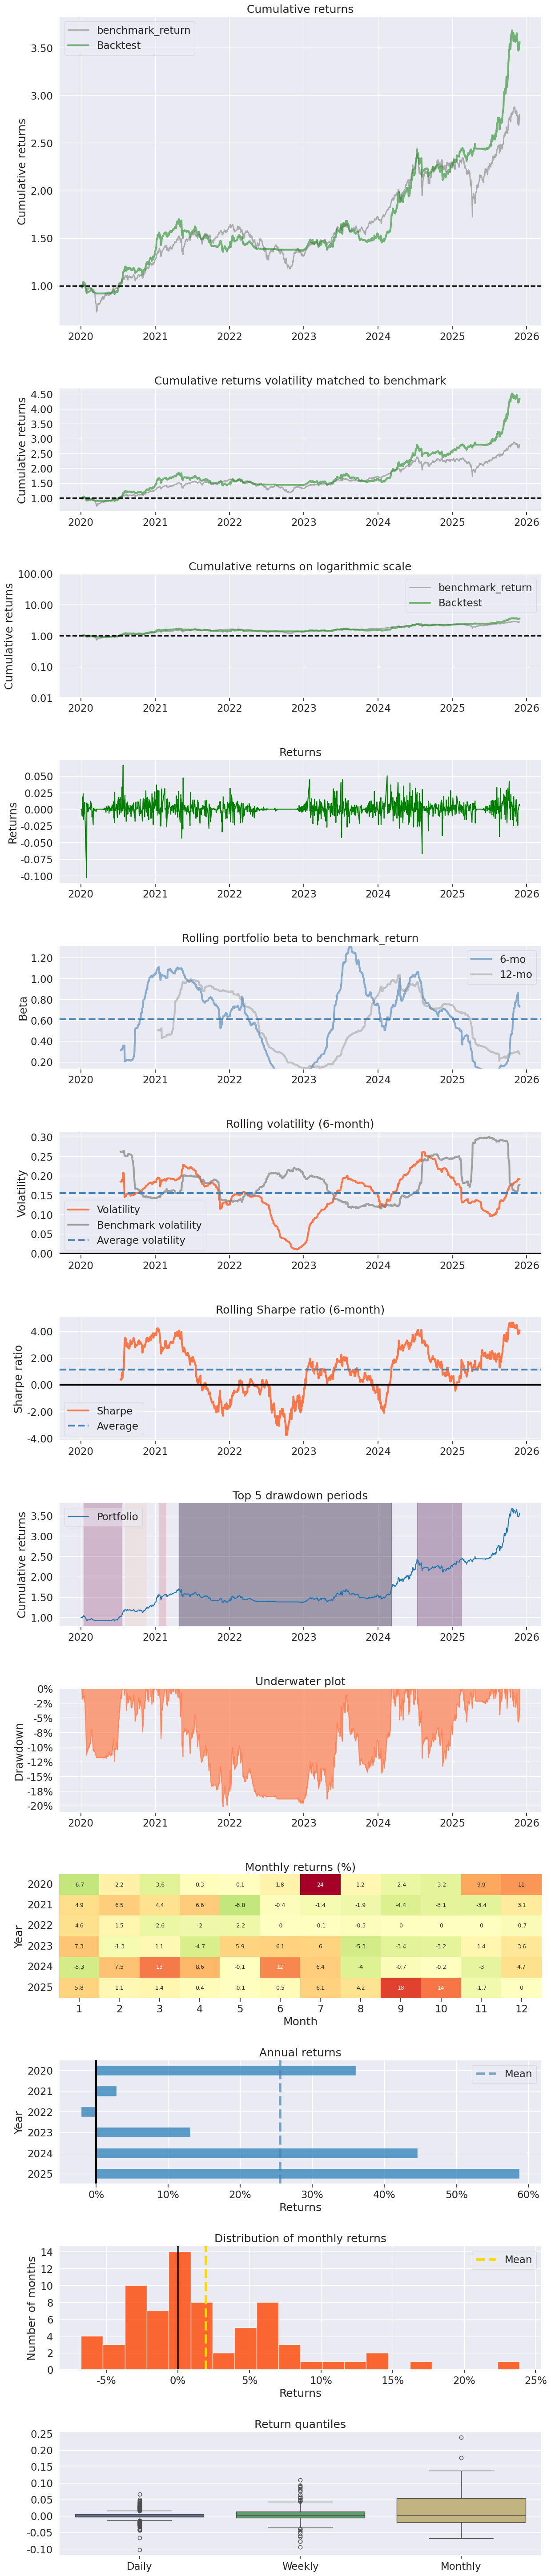

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

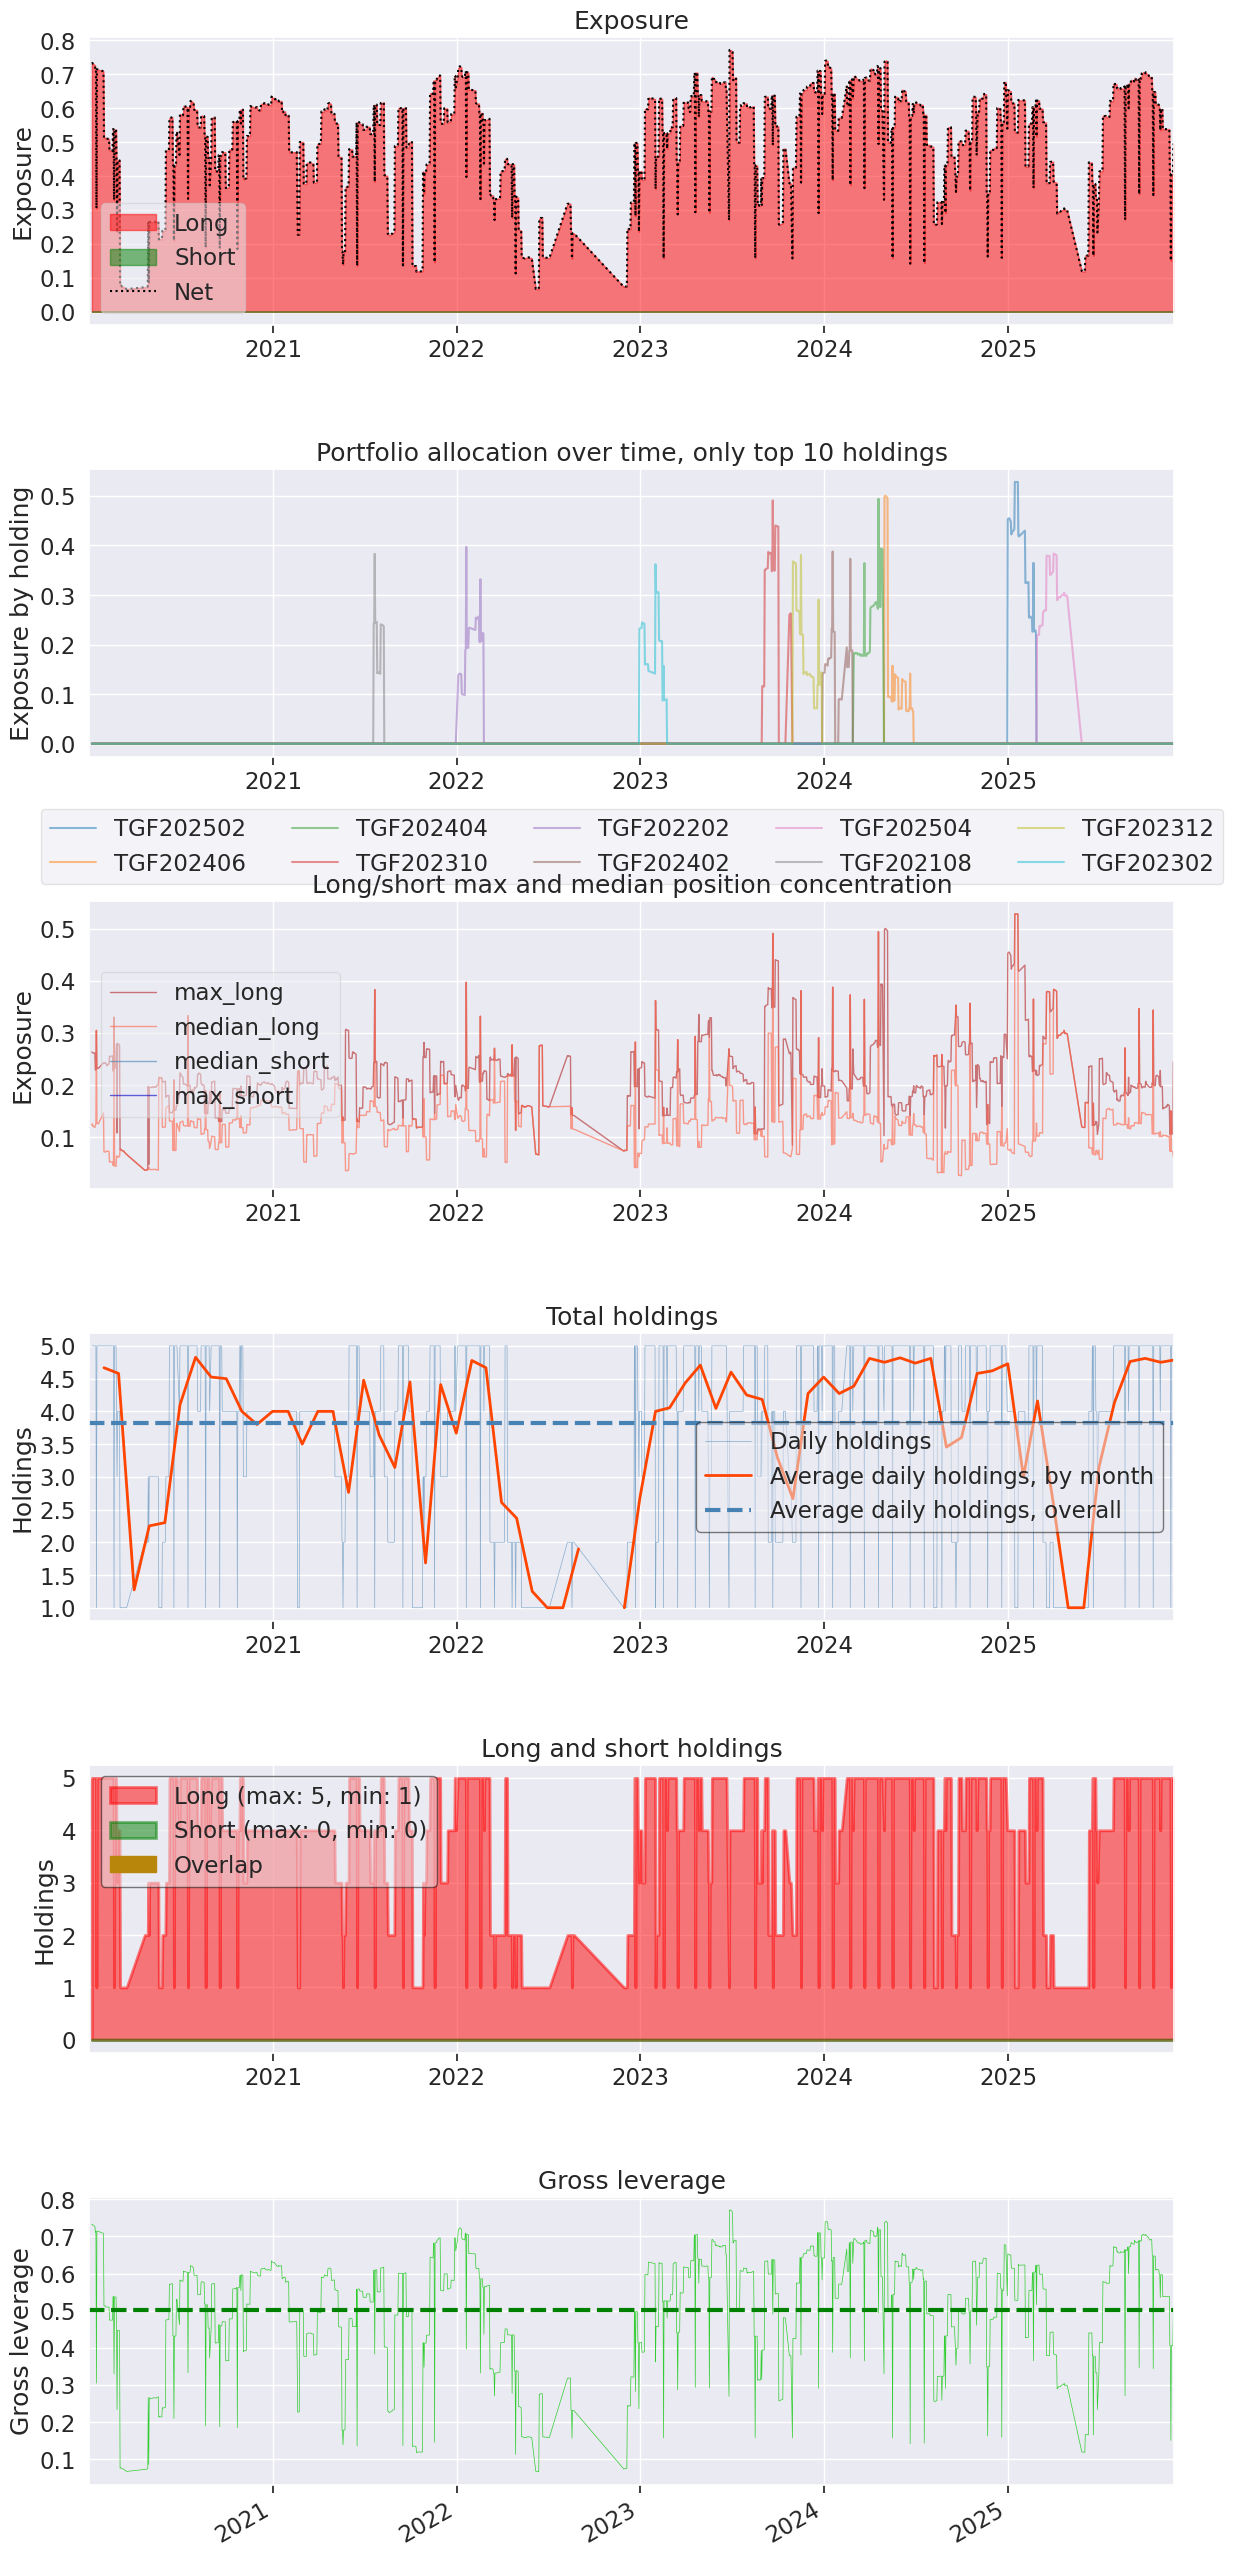

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

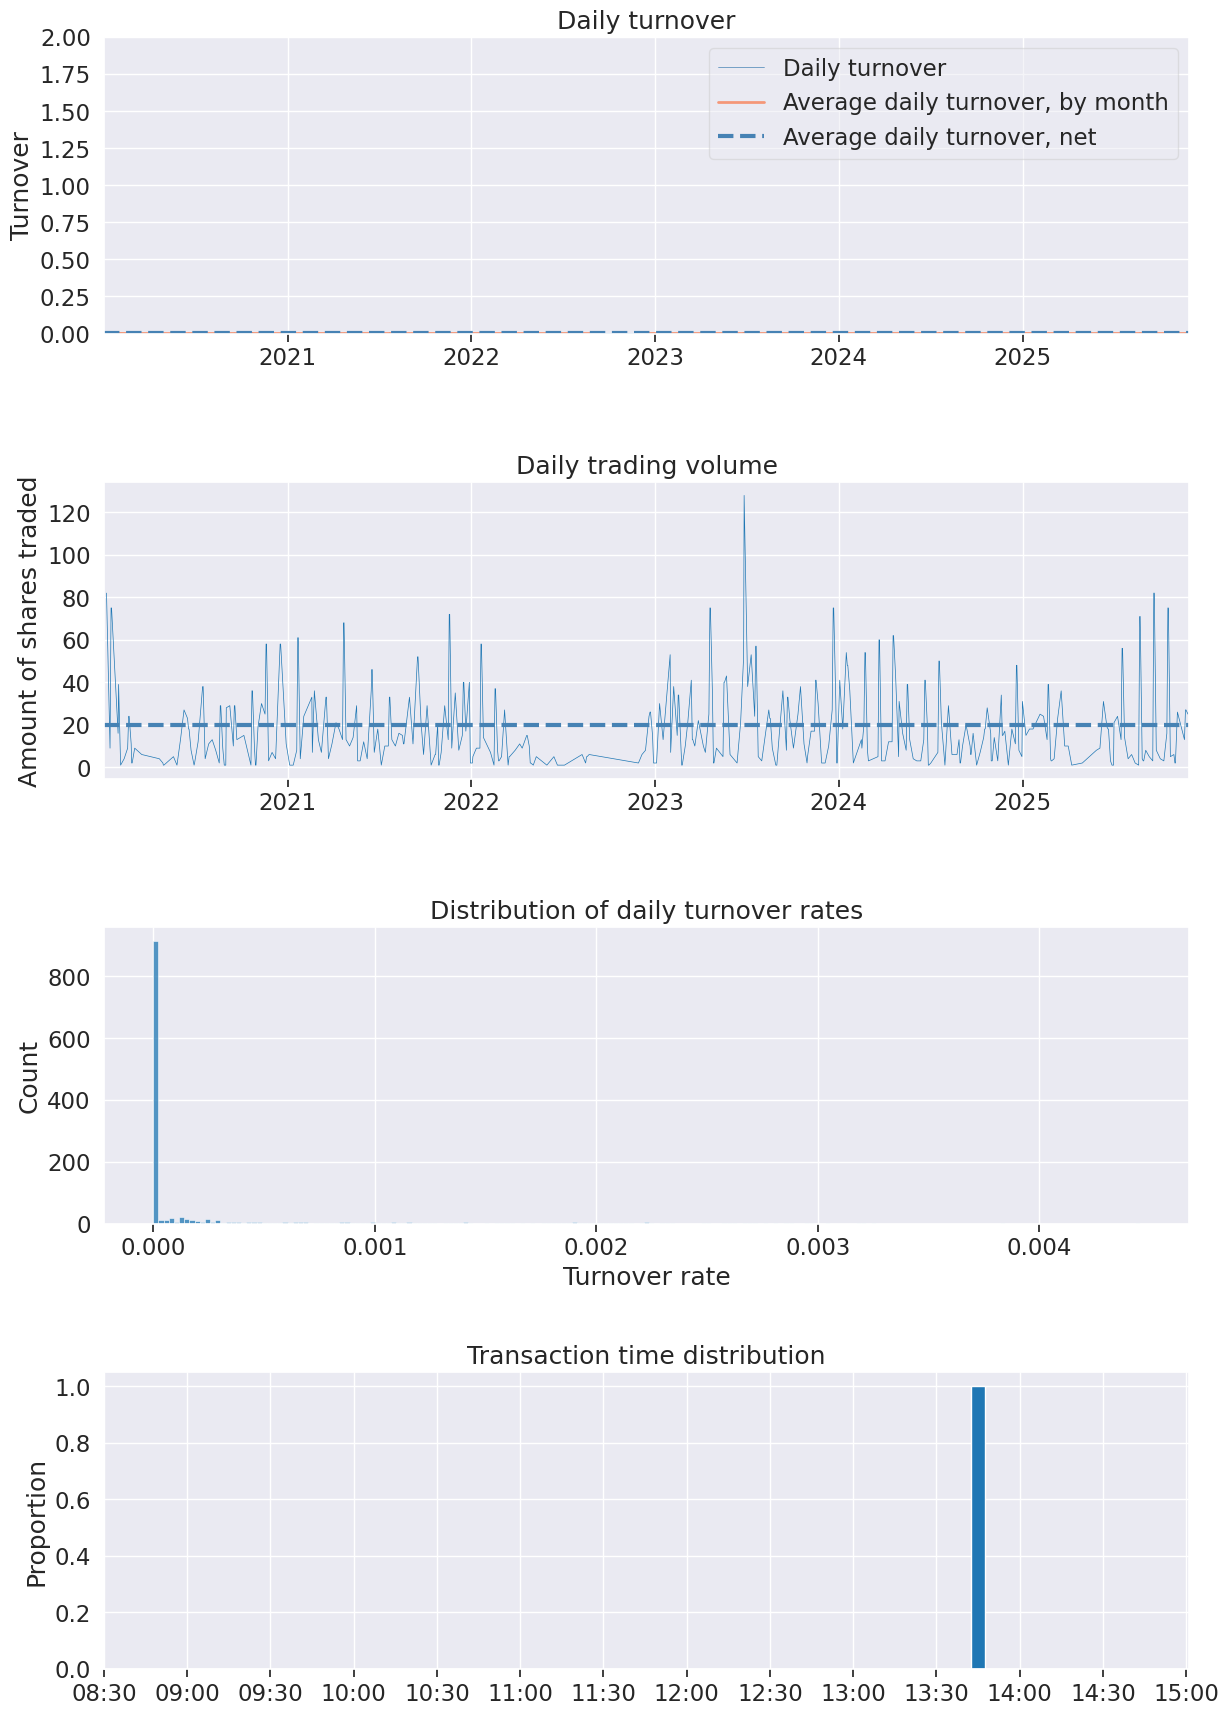

In [4]:
print("------ 大盤績效指標 ------")
pf.show_perf_stats(benchmark_rets)
print("------ 策略績效 ------")
pf.create_full_tear_sheet(
    returns,
    benchmark_rets=benchmark_rets,
    positions=positions,
    transactions=transactions,
    round_trips=False
)